![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting Nexus data 

- `1420*1420 *310*float32` Each timestep is **2 GiB**
- 900 timesteps **2TB**

In [1]:
import os ,sys, time, logging,shutil
from datetime import datetime
import numpy as np

t1 = time.time()

# python3 -m pip install nexusformat
from nexusformat.nexus import * 

from nexusformat.nexus.tree import NX_CONFIG
NX_CONFIG['memory']=4000

a=nxload(r'C:\visus_datasets\3scans_HKLI.nxs')
print(a.tree)

data = a.entry.data.counts.nxdata
D,H,W=data.shape
m,M=np.min(data),np.max(data)
print(f"Nexus load done in {time.time()-t1} seconds \ndtype={data.dtype} \nshape={data.shape} c_size={W*H*D*4:,} \nm={m} M={M}")

root:NXroot
  @HDF5_Version = '1.12.1'
  @file_name = '/nfs/chess/id4baux/2022-3/clancy-3316-a/CaYIrO...'
  @file_time = '2022-12-14T22:23:39.738282'
  @h5py_version = '3.7.0'
  @nexusformat_version = '0.7.6'
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
        @long_name = 'counts'


c:\Python38\lib\site-packages\nexusformat\nexus\tree.py:3750: RuntimeWarning: overflow encountered in long_scalars
  if (np.prod(self.shape) * np.dtype(self.dtype).itemsize


Nexus load done in 9.93101692199707 seconds 
dtype=float32 
shape=(1420, 1420, 310) c_size=2,500,336,000 
m=0.0 M=384713.5


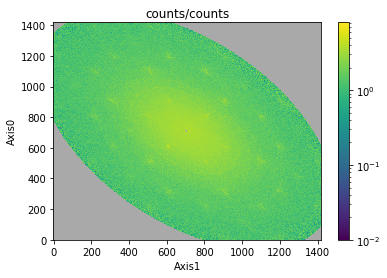

In [2]:
a.entry.data.counts[:,:,100].plot(log=True)

H [-7.1  -7.09 -7.08 ...  7.07  7.08  7.09]
K [-7.1  -7.09 -7.08 ...  7.07  7.08  7.09]
L [-3.1  -3.08 -3.06 ...  3.04  3.06  3.08]


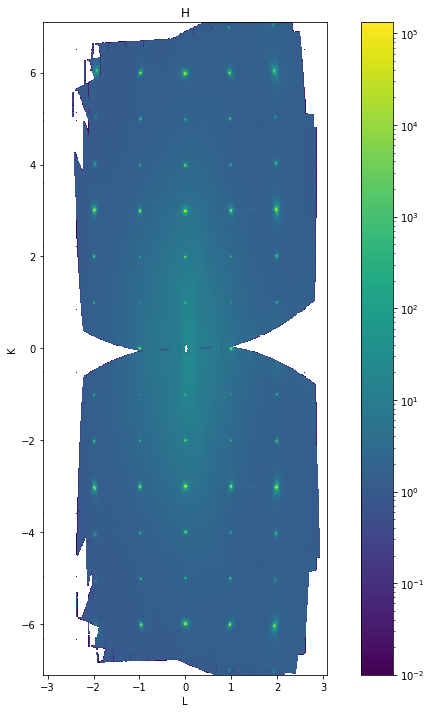

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# H,K,L:
print("H",a.entry.data.H.nxdata)
print("K",a.entry.data.K.nxdata)
print("L",a.entry.data.L.nxdata)
axis=[
	tuple(a.entry.data.H.nxdata), # z
	tuple(a.entry.data.K.nxdata), # y
	tuple(a.entry.data.L.nxdata)  # x
]

fig, ax = plt.subplots(figsize=(12, 12))

y1,y2=axis[-2][0],axis[-2][-1]
x1,x2=axis[-1][0],axis[-1][-1]

ax.set_title("H")
ax.set_ylabel("K")
ax.set_xlabel("L")

# https://h5web.panosc.eu/h5wasm
# nexpy (viewer)

img=data[1420//2,:,:]
vmin = np.nanmin(img[img > -np.inf])
vmax = np.nanmax(img[img <  np.inf])
pos=ax.imshow(np.flip(img,axis=0),origin="upper",
	norm=colors.LogNorm(
		max(vmin, 0.01), 
		max(vmax, 0.01)
	),
	cmap="viridis", 
	extent=[x1,x2,y1,y2])

# ax.set_aspect('equal')
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)

fig.colorbar(pos, ax=ax,location='right')
plt.autoscale(True)
plt.show()


# Show slice

ShowData dtype=float32 shape=(1420, 310) m=0.0 M=384713.5


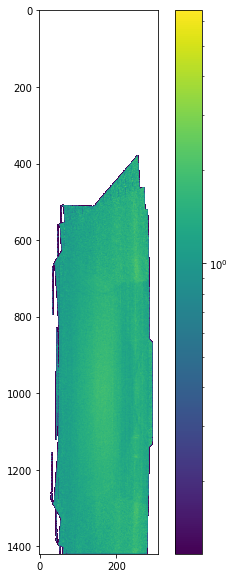

In [8]:
import matplotlib.pyplot as plt
from scipy import ndimage
import matplotlib.colors as colors

def ShowData(slice,cmap="viridis"):
	# m,M=np.min(slice),np.max(slice)
	print(f"ShowData dtype={slice.dtype} shape={slice.shape} m={m} M={M}")
	plt.subplots(nrows=1, figsize=(6,10))
	plt.imshow(slice, cmap=cmap, norm=colors.LogNorm())
	plt.colorbar()
	plt.show()

Z=data.shape[2]//2
ShowData(data[Z,:,:])

# Import OpenVisus

In [92]:
# import 
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
import OpenVisus as ov

os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
# ov.SetupLogger(logger, output_stdout=True) # for debugging
print("OpenVisus imported")

ModuleNotFoundError: No module named 'OpenVisus'

# Create OpenVisus file

In [ ]:
idx_filename="/mnt/data1/nsdf/tmp/3scans_HKLI/visus.idx"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

fields=[ov.Field("data",str(data.dtype),"row_major")]

# NOTE: we are first creating the dataset with no-compression
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
	compression="raw")

print(db.getDatasetBody().toString())
print("Dataset created")

<dataset url="/mnt/data1/nsdf/tmp/3scans_HKLI/visus.idx" cache_dir="" typename="IdxDataset">
	<idxfile>
		<version value="6" />
		<bitmask value="V1212012012012012012012012012012" />
		<box value="0 310 0 1420 0 1420" />
		<bitsperblock value="16" />
		<blocksperfile value="512" />
		<block_interleaving value="0" />
		<filename_template value="./visus/%04x.bin" />
		<missing_blocks value="False" />
		<arco value="0" />
		<time_template value="" />
		<field name="data" description="" index="" default_compression="" default_layout="" default_value="0" filter="" dtype="float32" />
		<timestep when="0" />
	</idxfile>
</dataset>
Dataset created


# Write  data to OpenVisus

In [ ]:
t1 = time.time()
db.write(data)
print(f"db.write done in {time.time() - t1} seconds")

db.write done in 2.5580971240997314 seconds


# Compress using zip

In [ ]:
t1 = time.time()
db.compressDataset(["zip"])
print(f"db.compressDataset done in {time.time()-t1} seconds")

db.compressDataset done in 12.035114049911499 seconds


# Show OpenVisus data

data ready
Filter took 4.445232391357422 seconds to compute
ShowData float32 (1420, 1420) 0.0 3.3507648


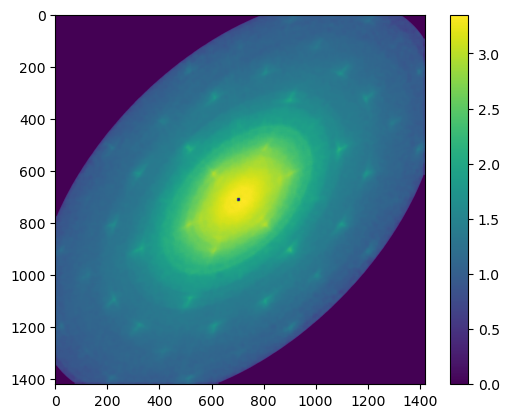

In [ ]:
import os,sys
slice=db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=1, quality=0)[:,:,0]
print("data ready")
ShowData(slice)

# Show coarse to fine

data ready
Filter took 0.44584012031555176 seconds to compute
ShowData float32 (355, 355) 0.0 3.3070538


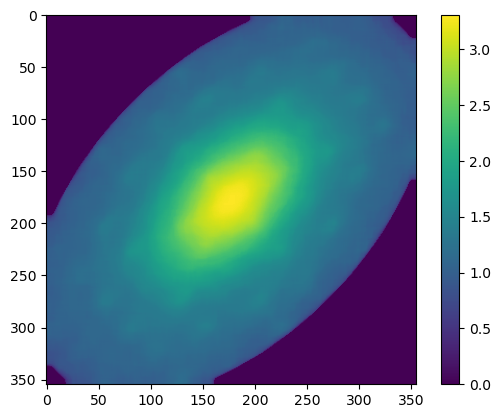

data ready
Filter took 1.3337419033050537 seconds to compute
ShowData float32 (710, 710) 0.0 3.3347137


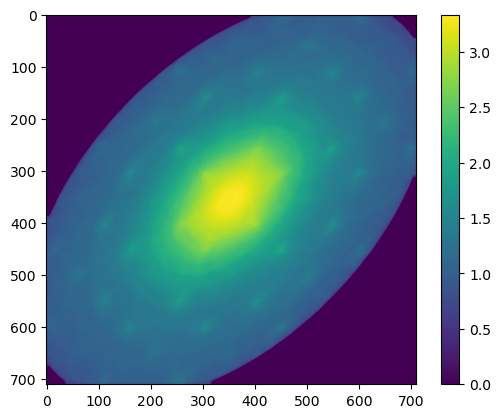

data ready
Filter took 4.5315752029418945 seconds to compute
ShowData float32 (1420, 1420) 0.0 3.3507648


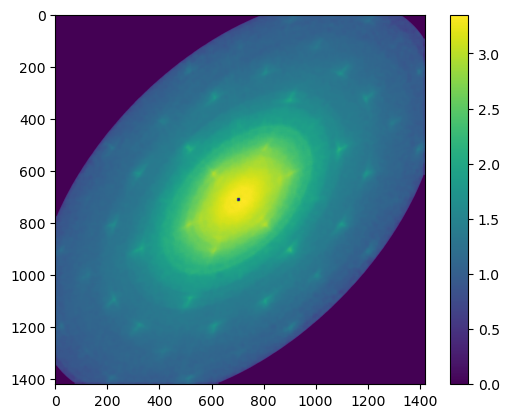

In [ ]:
import os,sys
for slice in db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=3, quality=0):
	print("data ready")
	ShowData(slice[:,:,0])

# Get from OpenVisus server

You need to 

- add the dataset to the `/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config`
- launch the Open Visus server


if you want to enable dynmamic dataset  you can do for example:

```
<visus> 

<Configuration> 
    <ModVisus> 
      <Dynamic enabled="true"  filename="/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config" msec="10000" /> 
    </ModVisus>
</Configuration>

<datasets>
    <dataset 
       name='recon_combined_1_fullres-arco-1mb' 
       url='/mnt/data1/nsdf/visus-datasets/chess/recon_combined_1_fullres/arco/1mb/zip/visus.idx'  />
</datasets>

</visus>
```

data ready
Filter took 4.529400587081909 seconds to compute
ShowData float32 (1420, 1420) 0.0 3.3507648


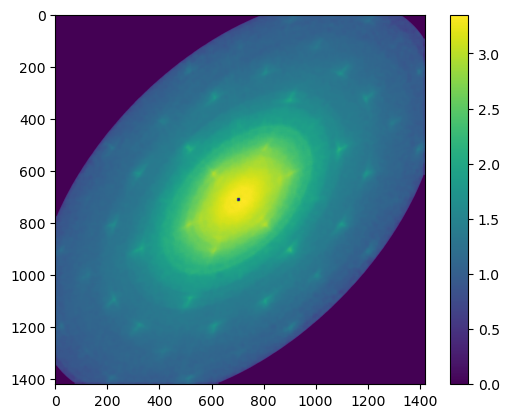

In [ ]:
# Get credentials to access the OpenVisus server
username,password=None,None
with open("/nfs/chess/nsdf01/openvisus/.mod_visus.identity.sh","rt") as file:
    for line in file.read().split():
        if "MODVISUS_USERNAME=" in line:
            username=line[line.index("MODVISUS_USERNAME=")+len("MODVISUS_USERNAME="):].strip()
            continue
        if "MODVISUS_PASSWORD=" in line:
            password=line[line.index("MODVISUS_PASSWORD=")+len("MODVISUS_PASSWORD="):].strip()
            continue

db=ov.LoadDataset(f"https://nsdf01.classe.cornell.edu/mod_visus?dataset=3scans_HKLI&~auth_username={username}&~auth_password={password}")
slice=db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=1, quality=0)[:,:,0]
print("data ready")
ShowData(slice)

# Streamable copy

In [ ]:
# https://github.com/nexpy/nexusformat/blob/main/src/nexusformat/nexus/tree.py

import copy,os,sys,time
from nexusformat.nexus import * 

from nexusformat.nexus.tree import NX_CONFIG 
NX_CONFIG['memory']=16000 # alllow data to be 16000MB (i.e. 16GB)

# ////////////////////////////////////////////////////////////
def StreamableCopy(src, max_field_bytes=1024*1024):
	def Simplify(obj):
		if isinstance(obj,NXfield) and obj.nbytes>max_field_bytes:
			# replace any 'big' field with something virtually empty
			obj.nxgroup[obj.nxname]=NXfield(value=None, shape=obj.shape, dtype=obj.dtype)
		if hasattr(obj,"items"):
			for name,child in obj.items():
					Simplify(child)
		return obj
	return Simplify(copy.deepcopy(src))

filename="C:/visus_datasets/3scans_HKLI.nxs"
streamable_filename=os.path.splitext(filename)[0]+".streamable.nxs"
if os.path.isfile(streamable_filename):
	os.remove(streamable_filename)
nxsave(streamable_filename, StreamableCopy(nxload(filename)) , mode='w')


In [ ]:
dst=nxload(streamable_filename)
print(dst.tree)

root:NXroot
  @HDF5_Version = '1.12.2'
  @file_name = 'C:\visus_datasets\3scans_HKLI.streamable.nxs'
  @file_time = '2023-09-04T11:08:23.951929'
  @h5py_version = '3.9.0'
  @nexusformat_version = '1.0.2'
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
